# Setup

In [1]:
import numpy as np
import pandas as pd
import random

from tabulate import tabulate
from tqdm import tqdm
import json

from minisom import MiniSom as SOM
from datetime import datetime

%run Code/plot_setup.py

%reload_ext autoreload
%autoreload 2

random.seed(123)
fig_path = "Figures_Plots/"

# Data

In [2]:
# initialise data
etf_data = pd.read_csv("Data/Data_ETFs_Info.csv")
etf_returns = pd.read_parquet("Data/Data_ETFs_Returns.gzip")

with open("Data/Data_ETFs_Names.json", "r") as openfile:
    # Reading from json file
    etf_dict = json.load(openfile)
    

etf_symbols = etf_dict.get("symbols")
etf_names = etf_dict.get("names")

# # date range
# start_date = "2015-01-01"
# end_date = "2022-12-01"

# start_date = str(etf_returns.index[0].date())
# end_date = str(etf_returns.index[-1].date())


## Train Test Split

In [3]:
from sklearn import preprocessing

# date where train ends
train_test_split = "2019-01-01"

# train test split
train_returns = etf_returns.loc[etf_returns.index < train_test_split, :]
test_returns = etf_returns.loc[etf_returns.index >= train_test_split, :]


# Should we standardize test with train ?
train_st_returns = train_returns.apply(preprocessing.scale)
test_st_returns = test_returns.apply(preprocessing.scale)

print(f"Train returns shape: \t{train_returns.shape}")
print(f"Test returns shape: \t{test_returns.shape}")

Train returns shape: 	(207, 663)
Test returns shape: 	(205, 663)


# Insights

## Data

In [4]:
etf_data.head()

,Symbol,ETF Name,Asset Class,Expense Ratio,region,Avg. Daily Volume
0,SPY,SPDR S&P 500 ETF Trust,Equity,0.0009,North America,9.199242e+07
1,IVV,iShares Core S&P 500 ETF,Equity,0.0003,North America,4.582045e+06
2,VOO,Vanguard S&P 500 ETF,Equity,0.0003,North America,3.382483e+06
3,VTI,Vanguard Total Stock Market ETF,Equity,0.0003,North America,3.364270e+06
4,QQQ,Invesco QQQ Trust,Equity,0.0020,North America,4.042276e+07


In [5]:
# Asset class count
tab = etf_data["Asset Class"].value_counts().to_frame()
tab["Percentage"] = tab.apply(lambda x: x/sum(tab["Asset Class"])*100)
print(tabulate(tab,  headers = ["Asset Class", "Count", "Ratio (%)"], floatfmt=["","0.0f", "0.1f"]))

Asset Class        Count    Ratio (%)
---------------  -------  -----------
Equity               462         70.4
Bond                 135         20.6
Real Estate           18          2.7
Commodity             17          2.6
Multi-Asset           11          1.7
Preferred Stock        6          0.9
Currency               5          0.8
Alternatives           2          0.3


In [6]:
# Region of etf count
tab = etf_data["region"].value_counts().to_frame()
tab["Percentage"] = tab.apply(lambda x: x/sum(tab["region"])*100)
print(tabulate(tab,  headers = ["Region", "Count", "Ratio (%)"], floatfmt=["","0.0f", "0.1f"]))

Region                   Count    Ratio (%)
---------------------  -------  -----------
North America              426         64.9
Developed Market            61          9.3
Global                      35          5.3
Developed Asia Pacifi       27          4.1
Emerging Asia Pacifi        26          4.0
Emerging Market             19          2.9
Global ex-U.S               16          2.4
Undefined                   14          2.1
Developed Europe            12          1.8
Broad Asia                  11          1.7
Latin America                7          1.1
Africa                       1          0.2
Middle East                  1          0.2


In [7]:
# Region vs Asset class count
tab = etf_data.value_counts(["region","Asset Class"]).to_frame().reset_index().pivot(index="region", columns="Asset Class", values=0)
# print(tabulate(tab,  headers = "keys"))
pd.DataFrame(tab)


Asset Class,Alternatives,Bond,Commodity,Currency,Equity,Multi-Asset,Preferred Stock,Real Estate
region,,,,,,,,
Africa,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
Broad Asia,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN
Developed Asia Pacifi,NaN,1.0,NaN,1.0,22.0,NaN,NaN,3.0
Developed Europe,NaN,1.0,NaN,2.0,9.0,NaN,NaN,NaN
Developed Market,NaN,16.0,NaN,NaN,41.0,1.0,NaN,3.0
Emerging Asia Pacifi,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN
Emerging Market,NaN,8.0,NaN,NaN,11.0,NaN,NaN,NaN
Global,2.0,10.0,3.0,NaN,18.0,2.0,NaN,NaN
Global ex-U.S,NaN,4.0,NaN,NaN,12.0,NaN,NaN,NaN


## Returns

In [8]:
from Code.functions import get_annualized_returns, get_annualized_std, sharpe_ratio, starr_ratio

etf_data["Annualized mean returns"] = get_annualized_returns(train_returns[etf_symbols["universe"]], "weekly")
etf_data["Annualized std"] = get_annualized_std(train_returns[etf_symbols["universe"]], "weekly")
etf_data["Annualized sharpe"] = sharpe_ratio(train_returns[etf_symbols["universe"]], "weekly")

etf_data["Annualized starr"] = starr_ratio(train_returns[etf_symbols["universe"]], "weekly")

In [9]:
tab = {
    "Annualized Returns (%)":etf_data["Annualized mean returns"].mean() * 100,
    "Annualized Std. of Returns (%)":etf_data["Annualized std"].mean() * 100,
    "Sharpe Ratio":etf_data["Annualized sharpe"].mean(),
    "Starr Ratio":etf_data["Annualized starr"].mean(),
    "Daily Traded Share Volume":etf_data["Avg. Daily Volume"].mean(),
    "Expense Ratio (%)":etf_data["Expense Ratio"].mean() * 100,
}

tab = pd.DataFrame(tab.values(), columns = ["Average"], index = tab.keys())

print(tabulate(tab, headers = "keys", floatfmt="0.2f", tablefmt = "latex"))

\begin{tabular}{lr}
\hline
                                &    Average \\
\hline
 Annualized Returns (\%)         &       3.03 \\
 Annualized Std. of Returns (\%) &      14.11 \\
 Sharpe Ratio                   &       0.36 \\
 Starr Ratio                    &       1.14 \\
 Daily Traded Share Volume      & 1600679.54 \\
 Expense Ratio (\%)              &       0.34 \\
\hline
\end{tabular}


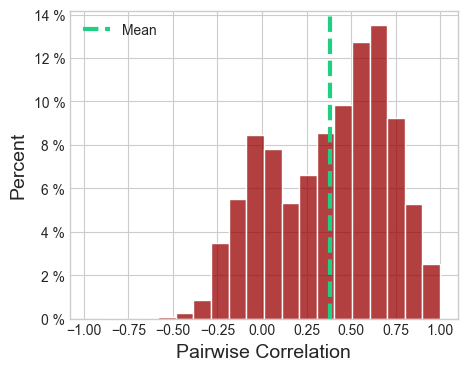

In [16]:
# number of etfs
n_etfs = etf_returns.shape[1]

# examine pairwise correlation
pairwise_corr = train_returns.corr("spearman").values[np.triu_indices(n = n_etfs, k=1)]

fig, ax = plt.subplots(figsize = (5,4))
sns.histplot(pairwise_corr, bins = 20, stat = "percent", ax = ax)
plt.axvline(x = pairwise_corr.mean(), color = colors["DTU Green"], label = "Mean", linestyle = "--")

tick_loc = ax.get_yticks()
tick_labels = [f"{tick:0.0f} %"  for tick in tick_loc]
ax.yaxis.set_major_locator(mticker.FixedLocator(tick_loc))
ax.set_yticklabels(tick_labels)

plt.legend()
#plt.title("Distribution of Pairwise Return Correlation")
plt.xlabel("Pairwise Correlation")
plt.ylabel("Percent")


plt.savefig(fig_path + 'insights_pairwise_correlation.png', bbox_inches='tight')
plt.show()

In [11]:
print(f"Average pairwise correlation: {pairwise_corr.mean():0.2f}")

Average pairwise correlation: 0.38


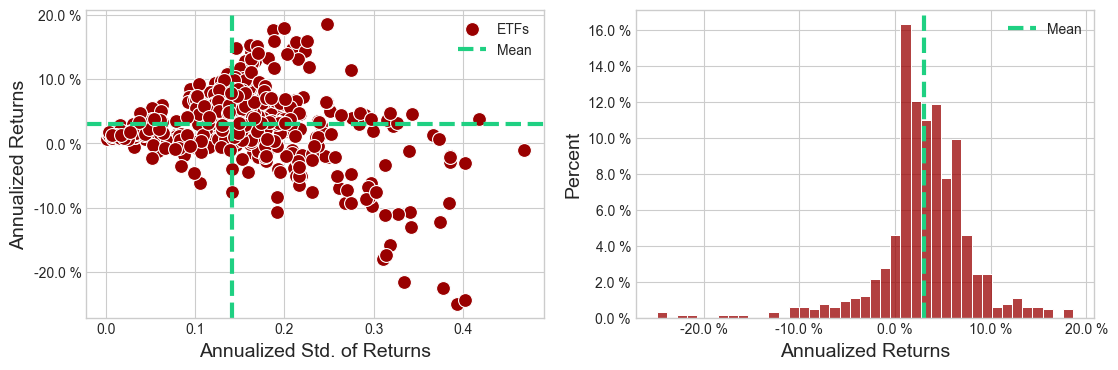

In [12]:
fig = plt.figure(figsize=(13, 4))
spec = fig.add_gridspec(
    1,2, 
    wspace = 0.20, 
    hspace=0.25
)

ax = fig.add_subplot(spec[0,0])
sns.scatterplot(
    data = etf_data,
    x = "Annualized std",
    y = "Annualized mean returns",
    label = "ETFs"
)

plt.axhline(y = etf_data["Annualized mean returns"].mean(), color = colors["DTU Green"], label = "Mean", linestyle = "--")
plt.axvline(x = etf_data["Annualized std"].mean(), color = colors["DTU Green"], linestyle = "--")

tick_loc = ax.get_yticks()
tick_labels = [f"{tick*100:0.1f} %"  for tick in tick_loc]
ax.yaxis.set_major_locator(mticker.FixedLocator(tick_loc))
ax.set_yticklabels(tick_labels)

#plt.title("ETF Universe Returns")
plt.xlabel("Annualized Std. of Returns")
plt.ylabel("Annualized Returns")
plt.legend()




ax = fig.add_subplot(spec[0,1])
sns.histplot(
    data = etf_data,
    x = "Annualized mean returns",
    stat = "percent"
)

tick_loc = ax.get_yticks()
tick_labels = [f"{tick:0.1f} %"  for tick in tick_loc]
ax.yaxis.set_major_locator(mticker.FixedLocator(tick_loc))
ax.set_yticklabels(tick_labels)

tick_loc = ax.get_xticks()
tick_labels = [f"{tick*100:0.1f} %"  for tick in tick_loc]
ax.xaxis.set_major_locator(mticker.FixedLocator(tick_loc))
ax.set_xticklabels(tick_labels)


#plt.title("ETF Universe Returns")
plt.axvline(x = etf_data["Annualized mean returns"].mean(), color = colors["DTU Green"], label = "Mean", linestyle = "--")
plt.xlabel("Annualized Returns")
plt.legend()

plt.savefig(fig_path + 'insights_return_distribution.png', bbox_inches='tight')
plt.show()

In [13]:
average_return = etf_data["Annualized mean returns"].mean()
average_std = etf_data["Annualized std"].mean()

print(f"Avergaeg Annualized mean returns: {average_return*100:0.2f} %")
print(f"Avergaeg Annualized std: {average_std:0.2f}")

Avergaeg Annualized mean returns: 3.03 %
Avergaeg Annualized std: 0.14


In [14]:

min_return = etf_data["Annualized mean returns"].min()
max_return = etf_data["Annualized mean returns"].max()

tmp = pd.DataFrame(index = np.linspace(-0.3, 0.3, num = 21, endpoint = True))

n = []
N = len(etf_data["Annualized mean returns"])
for i in tmp.index:
    count = (etf_data["Annualized mean returns"] <= i).sum()/N
    n.append(count)
    
tmp["n"] = n


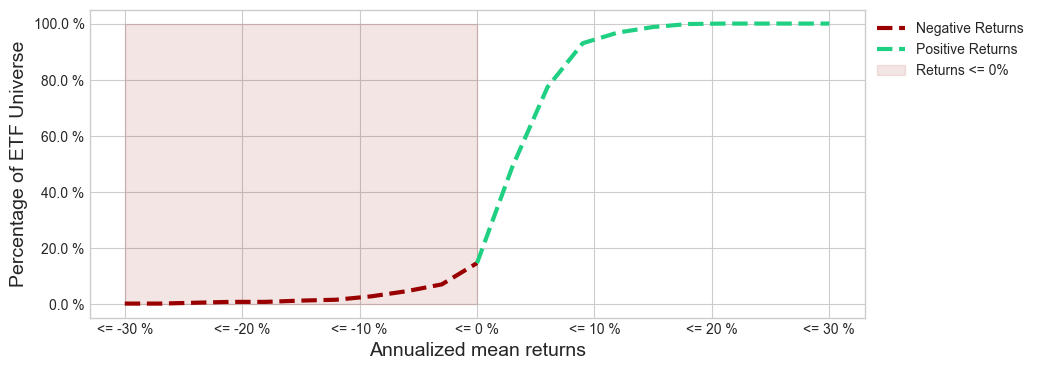

In [15]:
import matplotlib.ticker as mticker

fig, ax = plt.subplots()
plt.plot(tmp[tmp.index <= 0].index, tmp[tmp.index <= 0], 
         linestyle = "dashed", color = colors["DTU Red"], label = "Negative Returns")
plt.plot(tmp[tmp.index >= 0].index, tmp[tmp.index >= 0], 
         linestyle = "dashed", color = colors["DTU Green"], label = "Positive Returns")

plt.fill_betweenx(y = [0,1], x1 =[-0.3, -0.3], color = colors["DTU Red"], alpha = 0.1, label = "Returns <= 0%")

# plt.xticks(np.arange(-0.3, 0.3 + 0.15, 0.15))
tick_loc = ax.get_xticks()
tick_labels = [f"<= {tick*100:0.0f} %"  for tick in tick_loc]
ax.xaxis.set_major_locator(mticker.FixedLocator(tick_loc))
ax.set_xticklabels(tick_labels)

tick_loc = ax.get_yticks()
tick_labels = [f"{tick*100:0.1f} %"  for tick in tick_loc]
ax.yaxis.set_major_locator(mticker.FixedLocator(tick_loc))
ax.set_yticklabels(tick_labels)

plt.xlabel("Annualized mean returns")
plt.ylabel("Percentage of ETF Universe")
#plt.title("ETF Universe Returns")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig(fig_path + 'insights_negative_return.png', bbox_inches='tight')
plt.show()

In [16]:
print(f"Percentage of ETFs with Annualized mean returns <= 0: {tmp.loc[0.00][0]*100:0.2f} %")

Percentage of ETFs with Annualized mean returns <= 0: 14.48 %


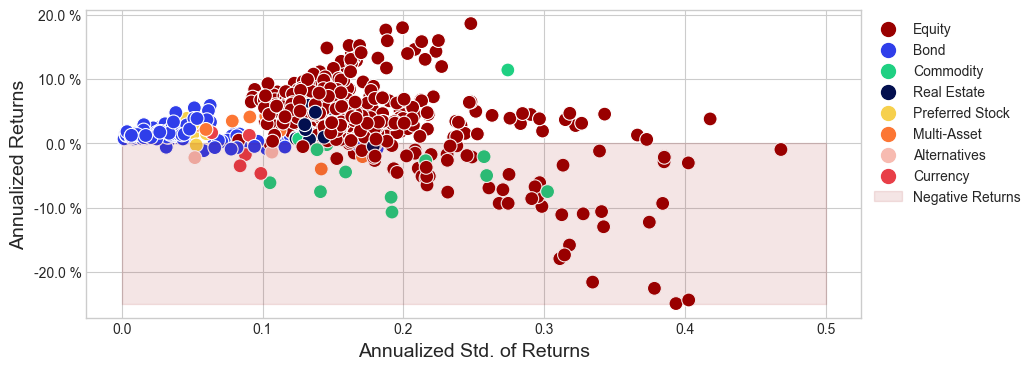

In [17]:

fig, ax = plt.subplots()
sns.scatterplot(
    data = etf_data,
    x = "Annualized std",
    y = "Annualized mean returns",
    hue = "Asset Class"
)

val = min(etf_data["Annualized mean returns"])
plt.fill_between(x = [0,0.5], y1 =[val, val], color = colors["DTU Red"], alpha = 0.1, label = "Negative Returns")

tick_loc = ax.get_yticks()
tick_labels = [f"{tick*100:0.1f} %"  for tick in tick_loc]
ax.yaxis.set_major_locator(mticker.FixedLocator(tick_loc))
ax.set_yticklabels(tick_labels)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.title("ETF Universe Returns")
plt.xlabel("Annualized Std. of Returns")
plt.ylabel("Annualized Returns")

plt.savefig(fig_path + 'insights_return_assetclasses.png', bbox_inches='tight')
plt.show()


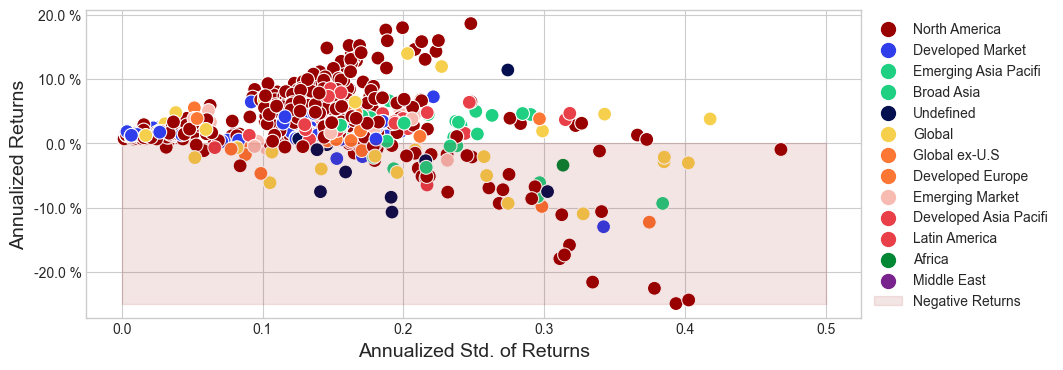

In [18]:
fig, ax = plt.subplots()
sns.scatterplot(
    data = etf_data,
    x = "Annualized std",
    y = "Annualized mean returns",
    hue = "region",
    palette = sns.mpl_palette("dtu_colors", n_colors = 13), 
)

val = min(etf_data["Annualized mean returns"])
plt.fill_between(x = [0,0.5], y1 =[val, val], color = colors["DTU Red"], alpha = 0.1, label = "Negative Returns")

tick_loc = ax.get_yticks()
tick_labels = [f"{tick*100:0.1f} %"  for tick in tick_loc]
ax.yaxis.set_major_locator(mticker.FixedLocator(tick_loc))
ax.set_yticklabels(tick_labels)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.title("ETF Universe Returns")
plt.xlabel("Annualized Std. of Returns")
plt.ylabel("Annualized Returns")

plt.savefig(fig_path + 'insights_return_regions.png', bbox_inches='tight')
plt.show()

## PCA

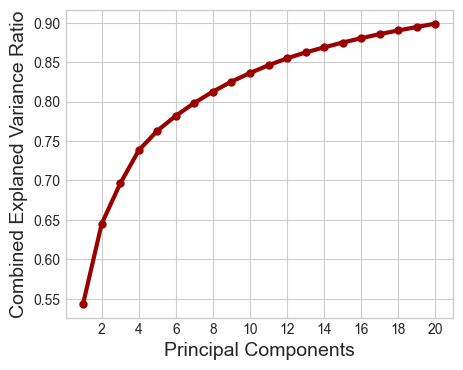

In [19]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

# pca on etf universe
pca = PCA().fit(train_returns)

# get explained variance ratio
W = pca.explained_variance_ratio_
n_components = 20


fig, ax = plt.subplots(figsize=(5, 4))

plt.plot(np.arange(n_components) + 1, np.cumsum(W[:n_components]), ".-")
plt.xticks(np.arange(2, n_components + 2, 2))
#plt.title("Principal Component Analysis (Sum)")
plt.xlabel("Principal Components")
plt.ylabel("Combined Explaned Variance Ratio")

plt.savefig(fig_path + 'insights_pca.png', bbox_inches='tight')
plt.show()

In [20]:
# from sklearn import preprocessing
# from sklearn.decomposition import PCA
# 
# # pca on etf universe
# pca = PCA().fit(train_returns)
# 
# # get explained variance ratio
# W = pca.explained_variance_ratio_
# n_components = 20
# 
# 
# fig = plt.figure(figsize=(13, 4))
# spec = fig.add_gridspec(
#     1,2, 
#     wspace = 0.20, 
#     hspace=0.25
# )
# 
# ax = fig.add_subplot(spec[0,0])
# plt.plot(np.arange(n_components) + 1, W[:n_components], ".-")
# plt.xticks(np.arange(1, n_components, 2))
# #plt.title("Principal Component Analysis")
# plt.xlabel("Principal Components")
# plt.ylabel("Explaned Variance Ratio")
# 
# ax = fig.add_subplot(spec[0,1])
# plt.plot(np.arange(n_components) + 1, np.cumsum(W[:n_components]), ".-")
# plt.xticks(np.arange(1, n_components, 2))
# #plt.title("Principal Component Analysis (Sum)")
# plt.xlabel("Principal Components")
# plt.ylabel("Combined Explaned Variance Ratio")
# 
# plt.savefig(fig_path + 'insights_pca.png', bbox_inches='tight')
# plt.show()

# Additional tables for paper

In [21]:
tmp_set = ["IHI", "LMBS", "VGT", "USDU", "SOXX", "RHS", "PSI", "IGV"]
tmp_train = train_returns[tmp_set]
tmp_test = test_returns[tmp_set]

In [22]:
from Code.functions import get_stats

tmp = {}
for sym in tmp_set:
    sym_ret = pd.DataFrame(tmp_train[sym], columns = [sym]) 
    tmp[sym] = get_stats(sym_ret)
    
tmp = pd.DataFrame(tmp).T.sort_values("Sharpe Ratio",ascending=False).T
print(tabulate(tmp, headers="keys", floatfmt="0.2f", tablefmt = "latex"))

\begin{tabular}{lrrrrrrrr}
\hline
                           &   LMBS &   IHI &   IGV &   VGT &   SOXX &   PSI &   RHS &   USDU \\
\hline
 Weekly mean Returns (\%)   &   0.06 &  0.29 &  0.35 &  0.28 &   0.33 &  0.33 &  0.09 &   0.04 \\
 Std of Weekly Returns (\%) &   0.22 &  2.02 &  2.60 &  2.26 &   2.95 &  3.12 &  1.45 &   0.89 \\
 Annualized Returns (\%)    &   2.89 & 14.82 & 17.61 & 14.11 &  15.80 & 15.97 &  4.49 &   1.65 \\
 Annualized Std (\%)        &   1.57 & 14.57 & 18.75 & 16.30 &  21.29 & 22.48 & 10.47 &   6.39 \\
 Sharpe Ratio              &   1.84 &  1.02 &  0.94 &  0.87 &   0.74 &  0.71 &  0.43 &   0.26 \\
 Starr Ratio               &   6.42 &  2.89 &  2.60 &  2.41 &   2.20 &  2.10 &  1.21 &   0.95 \\
 CVaR (\%)                  &  -0.45 & -5.12 & -6.77 & -5.86 &  -7.19 & -7.60 & -3.70 &  -1.74 \\
\hline
\end{tabular}


In [23]:
from Code.functions import get_stats

tmp = {}
for sym in tmp_set:
    sym_ret = pd.DataFrame(tmp_test[sym], columns = [sym]) 
    tmp[sym] = get_stats(sym_ret)
    
tmp = pd.DataFrame(tmp).T.sort_values("Sharpe Ratio",ascending=False).T
print(tabulate(tmp, headers="keys", floatfmt="0.2f", tablefmt = "latex"))

\begin{tabular}{lrrrrrrrr}
\hline
                           &   RHS &   VGT &   SOXX &    PSI &   IHI &   IGV &   USDU &   LMBS \\
\hline
 Weekly mean Returns (\%)   &  0.27 &  0.44 &   0.58 &   0.59 &  0.30 &  0.31 &   0.04 &   0.01 \\
 Std of Weekly Returns (\%) &  2.06 &  3.44 &   4.59 &   5.00 &  3.03 &  3.92 &   0.93 &   0.31 \\
 Annualized Returns (\%)    & 13.53 & 22.11 &  27.84 &  27.24 & 13.87 & 12.90 &   2.12 &   0.35 \\
 Annualized Std (\%)        & 14.84 & 24.80 &  33.10 &  36.09 & 21.83 & 28.25 &   6.67 &   2.27 \\
 Sharpe Ratio              &  0.91 &  0.89 &   0.84 &   0.75 &  0.64 &  0.46 &   0.32 &   0.16 \\
 Starr Ratio               &  2.66 &  2.54 &   2.65 &   2.37 &  1.78 &  1.32 &   1.12 &   0.46 \\
 CVaR (\%)                  & -5.08 & -8.70 & -10.51 & -11.51 & -7.78 & -9.74 &  -1.89 &  -0.78 \\
\hline
\end{tabular}
